In [8]:
# analyse_dns_csvs.py
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse

# ----------------- USER PATHS -----------------
PATH_ALL = "/Users/tejasmacipad/Desktop/CN/FinalProject/CN_Project/Report/Direct_query/dns_cf_do53.csv"
PATH_TOP = "/Users/tejasmacipad/Desktop/CN/FinalProject/CN_Project/Report/Direct_query/dns_cf_do53_top.csv"
OUT_DIR  = "./figs"  # where to save figures
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------- HELPERS -----------------
def extract_host(s: str) -> str:
    """
    Accepts domain strings that may be plain hosts or Markdown URLs like [https://www.ex.co](https://www.ex.co)
    and returns a lowercase host without scheme/port/brackets.
    """
    if s is None:
        return ""
    t = str(s).strip()
    # If Markdown-like [url](url), take inside the [] first
    if t.startswith("[") and "](" in t and t.endswith(")"):
        m = re.search(r"\[(.*?)\]", t)
        if m:
            t = m.group(1)
    # If there's a scheme, parse as URL; else treat as host
    if "://" in t:
        p = urlparse(t)
        host = p.netloc
    else:
        host = t
    # Strip creds/port/dots and lower
    host = host.split("@")[-1].split(":")[0].strip().strip(".").lower()
    # IDNA -> ASCII for safety
    try:
        host = host.encode("idna").decode("ascii")
    except Exception:
        pass
    return host

def coerce_numeric(series, default=np.nan):
    return pd.to_numeric(series, errors="coerce").fillna(default)

def load_and_clean(path: str, label: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Clean domain field
    df["domain_clean"] = df["domain"].apply(extract_host)
    # Ensure numeric
    df["rtt_ms"]   = coerce_numeric(df.get("rtt_ms"))
    df["bytes_out"] = coerce_numeric(df.get("bytes_out"))
    df["bytes_in"]  = coerce_numeric(df.get("bytes_in"))
    df["dataset"]   = label
    # Keep only rows that have at least a domain and status
    df = df[(df["domain_clean"] != "") & df["status"].notna()]
    return df

def ecdf(values: np.ndarray):
    x = np.sort(values)
    if len(x) == 0:
        return np.array([]), np.array([])
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

def percentiles(series: pd.Series, qs=(50, 90, 95, 99)):
    res = {}
    for q in qs:
        res[f"p{q}"] = float(np.percentile(series.dropna().values, q)) if series.notna().any() else np.nan
    return res

# ----------------- LOAD -----------------
dfa = load_and_clean(PATH_ALL, "All")
dft = load_and_clean(PATH_TOP, "Top50")

# Filter to successful queries with valid RTTs
succ_a = dfa[(dfa["status"] == "SUCCESS") & dfa["rtt_ms"].notna()]
succ_t = dft[(dft["status"] == "SUCCESS") & dft["rtt_ms"].notna()]

# ----------------- FIG 1: CDF of rtt_ms -----------------
plt.figure(figsize=(8,5))
xa, ya = ecdf(succ_a["rtt_ms"].values)
xt, yt = ecdf(succ_t["rtt_ms"].values)
if len(xa): plt.plot(xa, ya, label="All (SUCCESS)")
if len(xt): plt.plot(xt, yt, label="Top50 (SUCCESS)")
plt.xlabel("DNS response time (ms)")
plt.ylabel("Cumulative probability")
plt.title("CDF of DNS query response times")
plt.grid(True, alpha=0.3)
plt.legend()
out1 = os.path.join(OUT_DIR, "cdf_rtt_ms.png")
plt.tight_layout()
plt.savefig(out1, dpi=150)
plt.close()

# ----------------- FIG 2: Success/Timeout/Error breakdown -----------------
def status_share(df, label):
    counts = df["status"].value_counts(dropna=False)
    share = (counts / counts.sum()).rename(label)
    return share

shares = pd.concat([status_share(dfa, "All"), status_share(dft, "Top50")], axis=1).fillna(0) * 100.0
shares = shares.loc[["SUCCESS","TIMEOUT","ERROR"]].fillna(0) if "ERROR" in shares.index else shares

ax = shares.T.plot(kind="bar", figsize=(8,5))
plt.ylabel("Percentage of queries (%)")
plt.title("Outcome breakdown by dataset")
plt.grid(axis="y", alpha=0.3)
plt.xticks(rotation=0)
out2 = os.path.join(OUT_DIR, "status_breakdown.png")
plt.tight_layout()
plt.savefig(out2, dpi=150)
plt.close()

# ----------------- FIG 3: Distribution comparison -----------------
# Use boxplot (or switch to violin) for successful RTTs
plot_df = pd.concat([
    succ_a.assign(group="All"),
    succ_t.assign(group="Top50")
], ignore_index=True)

plt.figure(figsize=(8,5))
plot_df.boxplot(column="rtt_ms", by="group", grid=True)
plt.title("DNS response time by dataset (SUCCESS only)")
plt.suptitle("")
plt.ylabel("rtt_ms")
out3 = os.path.join(OUT_DIR, "box_rtt_ms.png")
plt.tight_layout()
plt.savefig(out3, dpi=150)
plt.close()

# ----------------- PRINT SUMMARY -----------------
def print_summary(name, df):
    s = df["rtt_ms"].dropna()
    pct = percentiles(s)
    total = len(df)
    succ = (df["status"] == "SUCCESS").sum()
    tout = (df["status"] == "TIMEOUT").sum()
    err  = (df["status"] == "ERROR").sum()
    print(f"[{name}] N={total}  SUCCESS={succ}  TIMEOUT={tout}  ERROR={err}")
    if len(s):
        print(f"  median={pct['p50']:.3f}ms  p90={pct['p90']:.3f}ms  p95={pct['p95']:.3f}ms  p99={pct['p99']:.3f}ms")

print_summary("All", dfa)
print_summary("Top50", dft)

print(f"\nSaved:\n  {out1}\n  {out2}\n  {out3}")


[All] N=50  SUCCESS=49  TIMEOUT=1  ERROR=0
  median=55.231ms  p90=778.214ms  p95=1504.937ms  p99=2824.251ms
[Top50] N=50  SUCCESS=50  TIMEOUT=0  ERROR=0
  median=27.754ms  p90=47.903ms  p95=52.633ms  p99=140.962ms

Saved:
  ./figs/cdf_rtt_ms.png
  ./figs/status_breakdown.png
  ./figs/box_rtt_ms.png


<Figure size 800x500 with 0 Axes>

Saved ./figs/cdf_with_inset.png


/var/folders/55/_kpfspls6xq0pzzm_dl4ylxc0000gn/T/ipykernel_74138/504033239.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


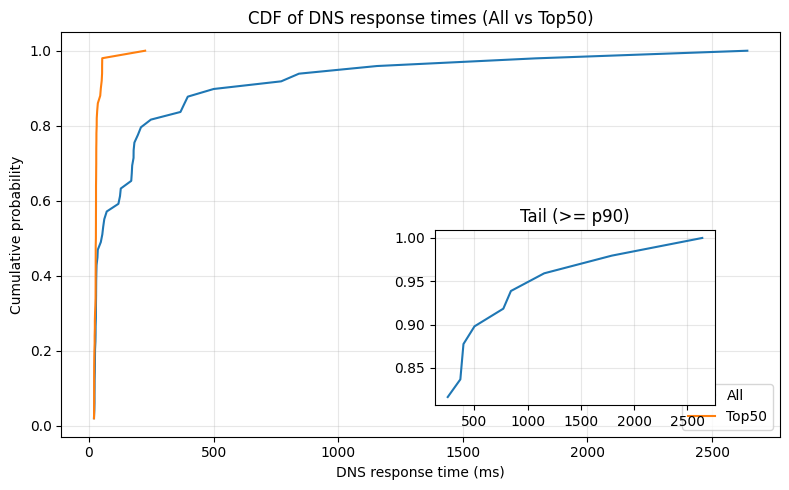

In [10]:
# fig_cdf_with_inset.py
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
# from analyse_dns_csvs import extract_host  # reuse helper if in same dir

PATH_ALL = "/Users/tejasmacipad/Desktop/CN/FinalProject/CN_Project/Report/Direct_query/dns_cf_do53.csv"
PATH_TOP = "/Users/tejasmacipad/Desktop/CN/FinalProject/CN_Project/Report/Direct_query/dns_cf_do53_top.csv"
OUT = "./figs/cdf_with_inset.png"
os.makedirs(os.path.dirname(OUT), exist_ok=True)

def load(path, label):
    df = pd.read_csv(path)
    df["domain_clean"] = df["domain"].apply(extract_host)
    df = df[(df["status"] == "SUCCESS") & pd.to_numeric(df["rtt_ms"], errors="coerce").notna()]
    x = np.sort(pd.to_numeric(df["rtt_ms"], errors="coerce").values)
    y = np.arange(1, len(x)+1)/len(x) if len(x) else np.array([])
    return x, y, label

xa, ya, la = load(PATH_ALL, "All")
xt, yt, lt = load(PATH_TOP, "Top50")

plt.figure(figsize=(8,5))
if len(xa): plt.plot(xa, ya, label=la)
if len(xt): plt.plot(xt, yt, label=lt)
plt.xlabel("DNS response time (ms)")
plt.ylabel("Cumulative probability")
plt.title("CDF of DNS response times (All vs Top50)")
plt.grid(True, alpha=0.3)
plt.legend()

# inset for tail (above p90 of combined)
comb = np.concatenate([xa, xt]) if len(xa) and len(xt) else (xa if len(xa) else xt)
if len(comb):
    p90 = np.percentile(comb, 90)
    inset = plt.axes([0.55, 0.18, 0.35, 0.35])
    if len(xa):
        m = xa >= p90
        inset.plot(xa[m], ya[m], label=la)
    if len(xt):
        m = xt >= p90
        inset.plot(xt[m], yt[m], label=lt)
    inset.set_title("Tail (>= p90)")
    inset.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT, dpi=150)
print("Saved", OUT)


Saved ./figs/outcome_by_rcode.png


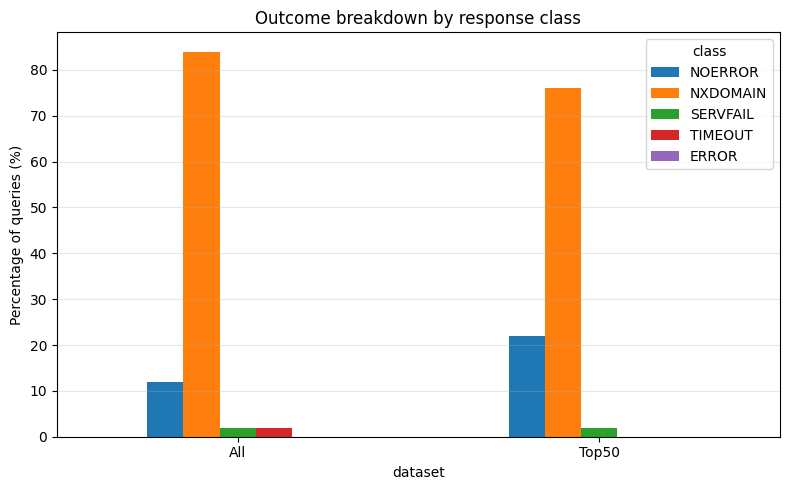

In [11]:
# fig_outcomes_by_rcode_standalone.py
import os, re
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse

PATHS = [
    ("/Users/tejasmacipad/Desktop/CN/FinalProject/CN_Project/Report/Direct_query/dns_cf_do53.csv", "All"),
    ("/Users/tejasmacipad/Desktop/CN/FinalProject/CN_Project/Report/Direct_query/dns_cf_do53_top.csv", "Top50"),
]
OUT = "./figs/outcome_by_rcode.png"
os.makedirs(os.path.dirname(OUT), exist_ok=True)

def extract_host(s: str) -> str:
    if s is None: return ""
    t = str(s).strip()
    m = re.search(r"\[(.*?)\]", t)
    if m: t = m.group(1)
    if "://" in t:
        p = urlparse(t)
        host = p.netloc
    else:
        host = t
    host = host.split("@")[-1].split(":")[0].strip().strip(".").lower()
    try:
        host = host.encode("idna").decode("ascii")
    except Exception:
        pass
    return host

rows = []
for path, label in PATHS:
    df = pd.read_csv(path)
    df["domain_clean"] = df["domain"].apply(extract_host)
    df["rcode"] = pd.to_numeric(df["rcode"], errors="coerce")
    total = len(df)
    counts = {
        "NOERROR": ((df["status"]=="SUCCESS") & (df["rcode"]==0)).sum(),
        "NXDOMAIN": ((df["status"]=="SUCCESS") & (df["rcode"]==3)).sum(),
        "SERVFAIL": ((df["status"]=="SUCCESS") & (df["rcode"]==2)).sum(),
        "TIMEOUT": (df["status"]=="TIMEOUT").sum(),
        "ERROR": (df["status"]=="ERROR").sum()
    }
    for cls, v in counts.items():
        rows.append({"dataset": label, "class": cls, "pct": (v/total)*100 if total else 0})

plot = pd.DataFrame(rows).pivot(index="dataset", columns="class", values="pct").fillna(0)
ax = plot[["NOERROR","NXDOMAIN","SERVFAIL","TIMEOUT","ERROR"]].plot(kind="bar", figsize=(8,5))
plt.ylabel("Percentage of queries (%)")
plt.title("Outcome breakdown by response class")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(OUT, dpi=150)
print("Saved", OUT)


Saved ./figs/pareto_tail_p95.png


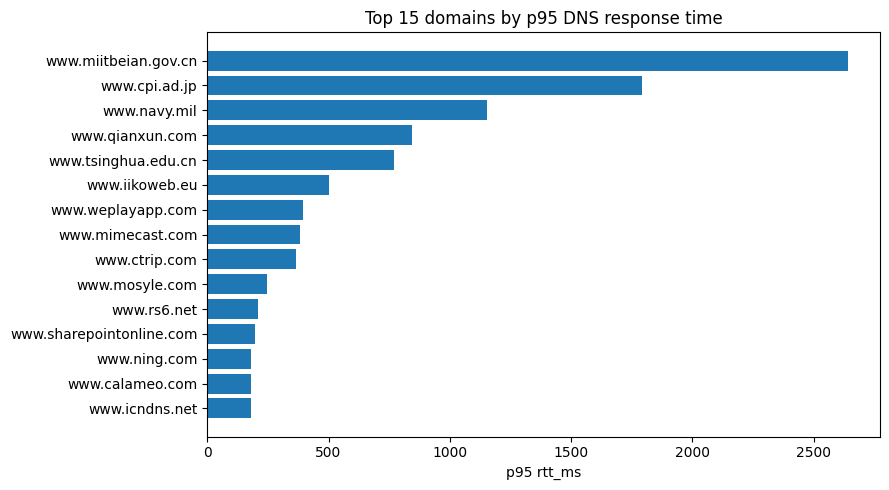

In [12]:
# fig_pareto_tail_domains_standalone.py
import os, re
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse

PATH = "/Users/tejasmacipad/Desktop/CN/FinalProject/CN_Project/Report/Direct_query/dns_cf_do53.csv"
OUT = "./figs/pareto_tail_p95.png"
os.makedirs(os.path.dirname(OUT), exist_ok=True)

def extract_host(s: str) -> str:
    if s is None: return ""
    t = str(s).strip()
    m = re.search(r"\[(.*?)\]", t)
    if m: t = m.group(1)
    if "://" in t:
        p = urlparse(t)
        host = p.netloc
    else:
        host = t
    host = host.split("@")[-1].split(":")[0].strip().strip(".").lower()
    try:
        host = host.encode("idna").decode("ascii")
    except Exception:
        pass
    return host

df = pd.read_csv(PATH)
df["domain_clean"] = df["domain"].apply(extract_host)
df["rtt_ms"] = pd.to_numeric(df["rtt_ms"], errors="coerce")
sdf = df[(df["status"]=="SUCCESS") & df["rtt_ms"].notna()].copy()

g = sdf.groupby("domain_clean")["rtt_ms"]
dom = pd.DataFrame({"p95": g.quantile(0.95), "count": g.count()}).dropna().sort_values("p95", ascending=False)
top = dom.head(15)

plt.figure(figsize=(9,5))
plt.barh(top.index[::-1], top["p95"][::-1])
plt.xlabel("p95 rtt_ms")
plt.title("Top 15 domains by p95 DNS response time")
plt.tight_layout()
plt.savefig(OUT, dpi=150)
print("Saved", OUT)


Saved ./figs/bytes_vs_latency.png


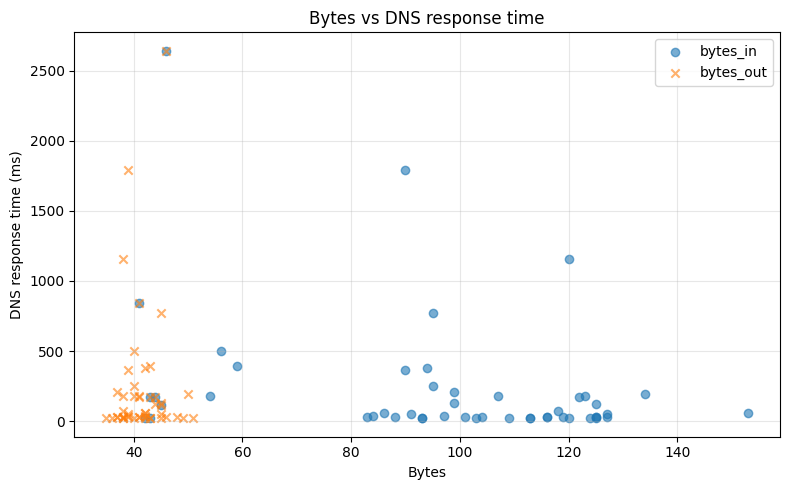

In [13]:
# fig_bytes_vs_latency_standalone.py
import os, re
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse

PATH = "/Users/tejasmacipad/Desktop/CN/FinalProject/CN_Project/Report/Direct_query/dns_cf_do53.csv"
OUT = "./figs/bytes_vs_latency.png"
os.makedirs(os.path.dirname(OUT), exist_ok=True)

def extract_host(s: str) -> str:
    if s is None: return ""
    t = str(s).strip()
    m = re.search(r"\[(.*?)\]", t)
    if m: t = m.group(1)
    if "://" in t:
        p = urlparse(t)
        host = p.netloc
    else:
        host = t
    host = host.split("@")[-1].split(":")[0].strip().strip(".").lower()
    try:
        host = host.encode("idna").decode("ascii")
    except Exception:
        pass
    return host

df = pd.read_csv(PATH)
df["domain_clean"] = df["domain"].apply(extract_host)
for c in ["rtt_ms","bytes_in","bytes_out"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
sdf = df[(df["status"]=="SUCCESS") & df["rtt_ms"].notna()]

plt.figure(figsize=(8,5))
plt.scatter(sdf["bytes_in"], sdf["rtt_ms"], alpha=0.6, label="bytes_in")
plt.scatter(sdf["bytes_out"], sdf["rtt_ms"], alpha=0.6, label="bytes_out", marker="x")
plt.xlabel("Bytes")
plt.ylabel("DNS response time (ms)")
plt.title("Bytes vs DNS response time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT, dpi=150)
print("Saved", OUT)
